In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_train = pd.read_csv("train.csv")
df_test  = pd.read_csv("test.csv")

print(df_train.shape, df_test.shape)
df_train.info()
df_train.describe()
df_train.isna().sum()


(11018, 36) (5000, 36)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11018 entries, 0 to 11017
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10488 non-null  object 
 1   Age                         10488 non-null  float64
 2   AnnualIncome                10488 non-null  float64
 3   CreditScore                 9987 non-null   float64
 4   LoanAmount                  9987 non-null   float64
 5   LoanDuration                10488 non-null  float64
 6   MaritalStatus               10488 non-null  object 
 7   NumberOfDependents          10488 non-null  float64
 8   HomeOwnershipStatus         10488 non-null  object 
 9   MonthlyDebtPayments         9987 non-null   float64
 10  CreditCardUtilizationRate   10488 non-null  float64
 11  NumberOfOpenCreditLines     10488 non-null  float64
 12  NumberOfCreditInquiries     10488 non-null  float64
 13  DebtToIn

ApplicationDate                530
Age                            530
AnnualIncome                   530
CreditScore                   1031
LoanAmount                    1031
LoanDuration                   530
MaritalStatus                  530
NumberOfDependents             530
HomeOwnershipStatus            530
MonthlyDebtPayments           1031
CreditCardUtilizationRate      530
NumberOfOpenCreditLines        530
NumberOfCreditInquiries        530
DebtToIncomeRatio              530
BankruptcyHistory             1031
LoanPurpose                   1031
PreviousLoanDefaults           530
PaymentHistory                 530
LengthOfCreditHistory          530
SavingsAccountBalance          530
CheckingAccountBalance        1031
TotalAssets                   1031
TotalLiabilities               530
MonthlyIncome                  530
UtilityBillsPaymentHistory     530
JobTenure                      530
EmploymentStatus               530
EducationLevel                 530
Experience          

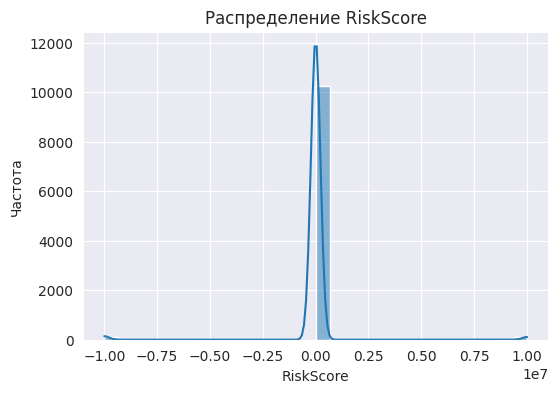

1% квантиль: -9999999.0 99% квантиль: 90.20634537706425


In [2]:
plt.figure(figsize=(6,4))
sns.histplot(df_train["RiskScore"], bins=30, kde=True)
plt.title("Распределение RiskScore")
plt.xlabel("RiskScore")
plt.ylabel("Частота")
plt.show()

q_low, q_high = df_train["RiskScore"].quantile([0.01, 0.99])
print("1% квантиль:", q_low, "99% квантиль:", q_high)


### Уберем из данных шумы и null

In [3]:
def clean_data(df_train, df_test, target="RiskScore"):
    import numpy as np

    # --- Категориальные ---
    cat_cols = df_train.select_dtypes(include="object").columns
    for col in cat_cols:
        df_train[col] = df_train[col].fillna("Unknown")
        df_test[col] = df_test[col].fillna("Unknown")

    # --- Числовые ---
    num_cols = df_train.select_dtypes(include="number").columns.drop(target, errors="ignore")
    for col in num_cols:
        median = df_train[col].median()
        df_train[col] = df_train[col].fillna(median)
        df_test[col] = df_test[col].fillna(median)

        low, high = df_train[col].quantile([0.01, 0.99])
        df_train[col] = df_train[col].clip(lower=low, upper=high)

    # --- Удаление строк с NaN в target (только train)
    df_train = df_train[df_train[target].notna()].reset_index(drop=True)

    return df_train, df_test

df_train, df_test = clean_data(df_train, df_test)



## 1.4 Корреляционная матрица


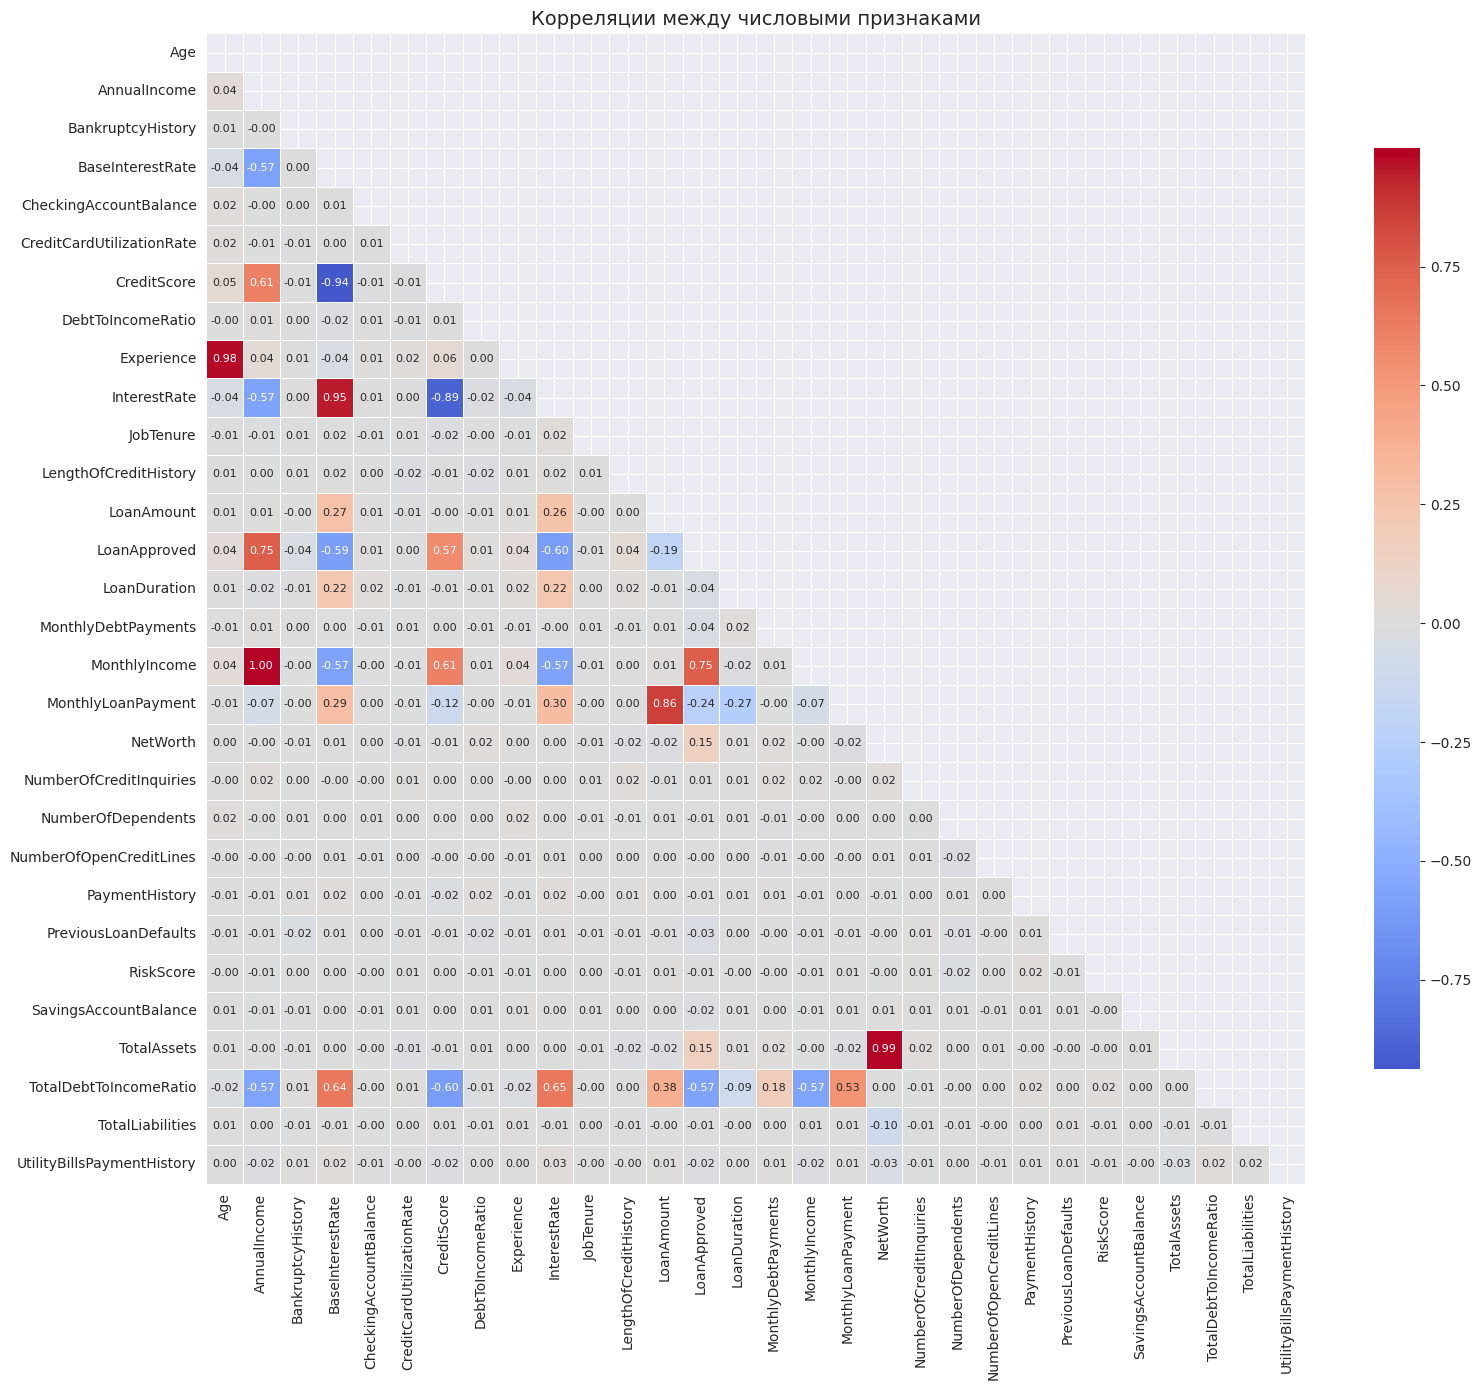

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = df_train.select_dtypes(include="number").columns.drop("RiskScore")
corr = df_train[num_cols.union(["RiskScore"])].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16,14))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}
)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title("Корреляции между числовыми признаками", fontsize=14)
plt.tight_layout()
plt.show()


In [5]:
num_cols = df_train.select_dtypes(include="number").columns.drop("RiskScore")
corr = df_train[num_cols].corr().abs()

mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
upper = corr.where(mask)

threshold = 0.1
high_corr_pairs = (
    upper.stack()
         .reset_index()
         .rename(columns={"level_0":"feature_1", "level_1":"feature_2", 0:"corr"})
         .query("corr > @threshold")
         .sort_values("corr", ascending=False)
)

print(high_corr_pairs.to_string(index=False))

             feature_1              feature_2     corr
          AnnualIncome          MonthlyIncome 0.998600
           TotalAssets               NetWorth 0.985783
                   Age             Experience 0.982832
      BaseInterestRate           InterestRate 0.951411
           CreditScore       BaseInterestRate 0.936729
           CreditScore           InterestRate 0.889994
            LoanAmount     MonthlyLoanPayment 0.855885
         MonthlyIncome           LoanApproved 0.754859
          AnnualIncome           LoanApproved 0.754230
          InterestRate TotalDebtToIncomeRatio 0.648352
      BaseInterestRate TotalDebtToIncomeRatio 0.643472
          AnnualIncome            CreditScore 0.612564
           CreditScore          MonthlyIncome 0.612409
           CreditScore TotalDebtToIncomeRatio 0.603496
          InterestRate           LoanApproved 0.603185
      BaseInterestRate           LoanApproved 0.593102
          AnnualIncome       BaseInterestRate 0.574238
         M

In [6]:
num_cols = df_train.select_dtypes(include="number").columns.drop("RiskScore")
print(df_train[num_cols].isna().sum())

Age                           0
AnnualIncome                  0
CreditScore                   0
LoanAmount                    0
LoanDuration                  0
NumberOfDependents            0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
PreviousLoanDefaults          0
PaymentHistory                0
LengthOfCreditHistory         0
SavingsAccountBalance         0
CheckingAccountBalance        0
TotalAssets                   0
TotalLiabilities              0
MonthlyIncome                 0
UtilityBillsPaymentHistory    0
JobTenure                     0
Experience                    0
NetWorth                      0
BaseInterestRate              0
InterestRate                  0
MonthlyLoanPayment            0
TotalDebtToIncomeRatio        0
LoanApproved                  0
dtype: int64


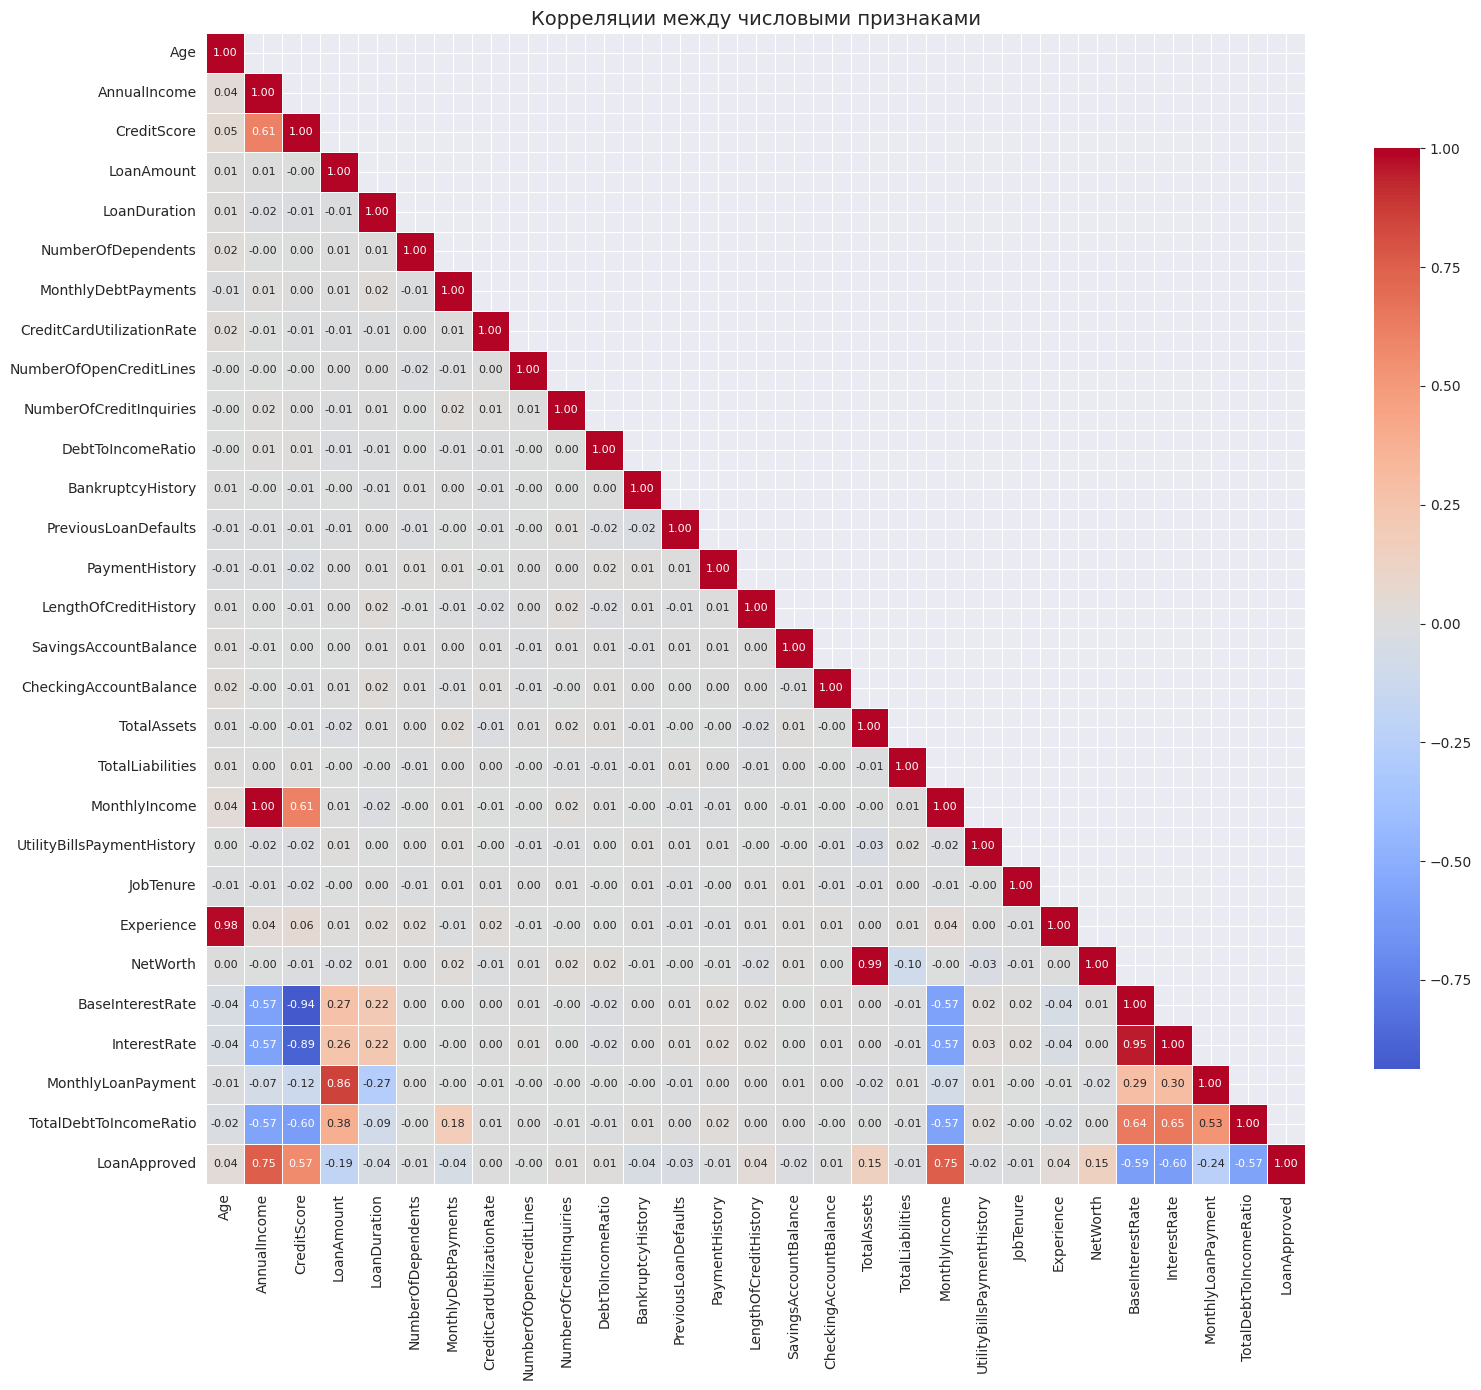

Нужно компонент k = 3 для 95% дисперсии
Собственные числа первых 3 компонентов: [1.55458552e+11 1.30635399e+10 1.27820700e+10]


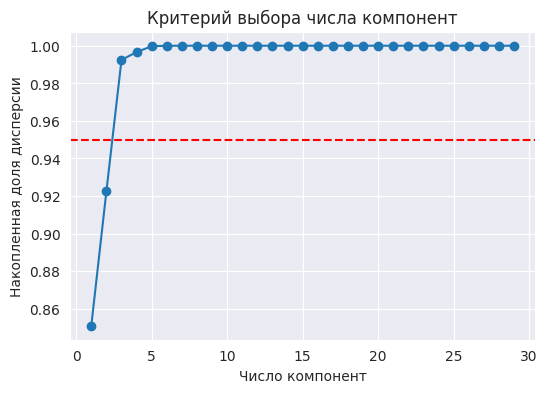

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pca import pca_manual, select_n_components

num_cols = df_train.select_dtypes(include="number").columns.drop("RiskScore")
df_num = df_train[num_cols].fillna(df_train[num_cols].median())
X = df_num.values

corr = df_num.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

plt.figure(figsize=(16,14))
sns.heatmap(
    corr,
    mask=mask,
    annot=True, fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}
)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title("Корреляции между числовыми признаками", fontsize=14)
plt.tight_layout()
plt.show()

k_calc, explained_ratio, cum_ratio = select_n_components(X, variance_threshold=0.95)
print(f"Нужно компонент k = {k_calc} для 95% дисперсии")

X_pca, components, explained_variance = pca_manual(X, n_components=k_calc)
print(f"Собственные числа первых {k_calc} компонентов:", explained_variance)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cum_ratio)+1), cum_ratio, marker="o")
plt.axhline(0.95, color="red", linestyle="--")
plt.xlabel("Число компонент")
plt.ylabel("Накопленная доля дисперсии")
plt.title("Критерий выбора числа компонент")
plt.grid(True)
plt.show()


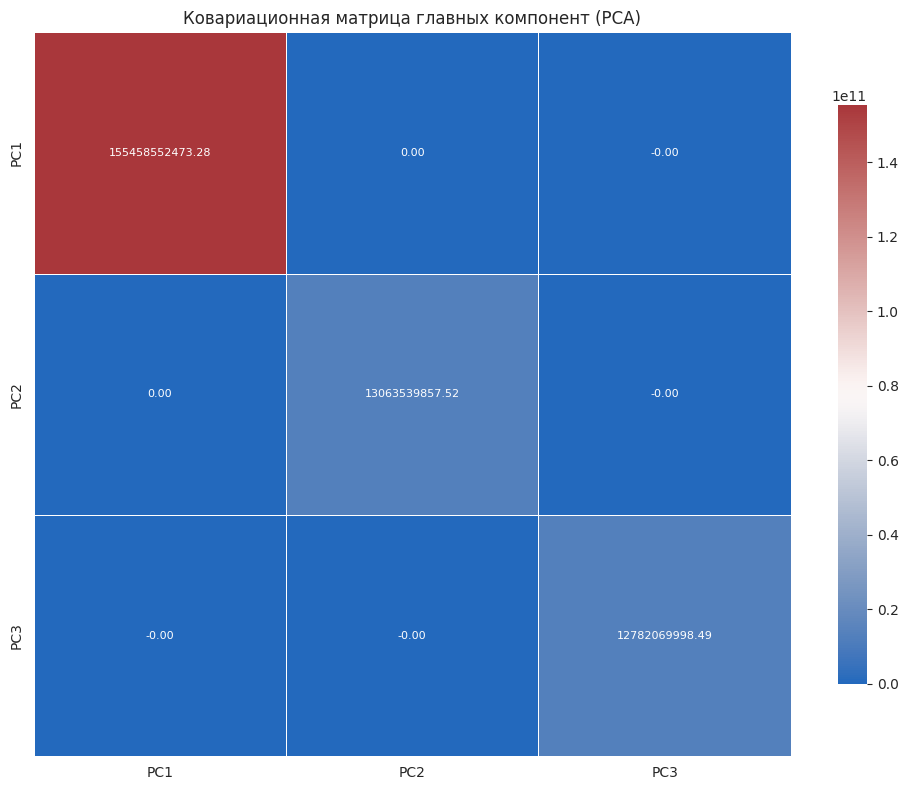

PC1 contribution: 0.8574461307233254
PC2 contribution: 0.0720531712547733


In [8]:
# 1. Центрируем результат (по строкам X_pca)
X_pca_c = X_pca - X_pca.mean(axis=0)

# 2. Ковариационная матрица компонент
cov_pca = np.cov(X_pca_c, rowvar=False)

# 3. Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(
    cov_pca,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    xticklabels=[f"PC{i+1}" for i in range(k_calc)],
    yticklabels=[f"PC{i+1}" for i in range(k_calc)],
    linewidths=0.5,
    annot_kws={"size": 8},
    cbar_kws={"shrink": 0.8}
)
plt.title("Ковариационная матрица главных компонент (PCA)")
plt.tight_layout()
plt.show()

total = sum(explained_variance)
print("PC1 contribution:", explained_variance[0] / total)  # ≈ 0.91
print("PC2 contribution:", explained_variance[1] / total)


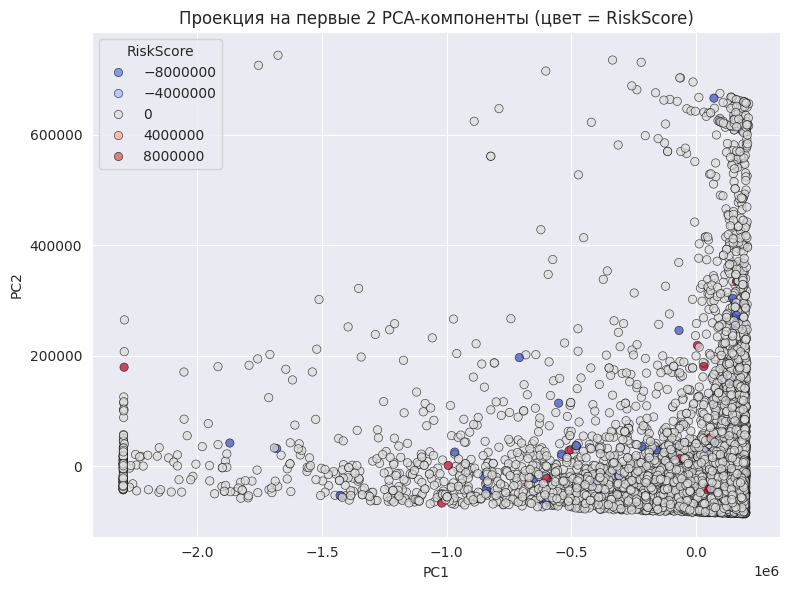

<Axes: xlabel='PC1', ylabel='RiskScore'>

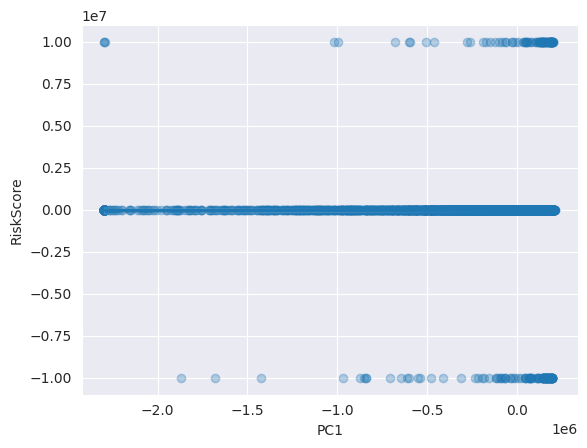

In [9]:
# 1. Возьмём только 2 главные компоненты
pc_df = pd.DataFrame(
    X_pca[:, :2],
    columns=["PC1", "PC2"]
)

# 2. Добавим к ним целевую переменную RiskScore
pc_df["RiskScore"] = df_train["RiskScore"].values

# 3. Визуализация: цвет по значению RiskScore
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pc_df,
    x="PC1",
    y="PC2",
    hue="RiskScore",
    palette="coolwarm",
    edgecolor="k",
    alpha=0.7
)
plt.title("Проекция на первые 2 PCA-компоненты (цвет = RiskScore)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="RiskScore")
plt.grid(True)
plt.tight_layout()
plt.show()

sns.regplot(data=pc_df, x="PC1", y="RiskScore", scatter_kws={"alpha": 0.3})


### Throw away PCA

In [10]:
q_low, q_high = df_train["RiskScore"].quantile([0.01, 0.99])
df_filtered = df_train[(df_train["RiskScore"] >= q_low) & (df_train["RiskScore"] <= q_high)]
print(f"Оставлено {len(df_filtered)} строк после обрезки выбросов")


Оставлено 10383 строк после обрезки выбросов


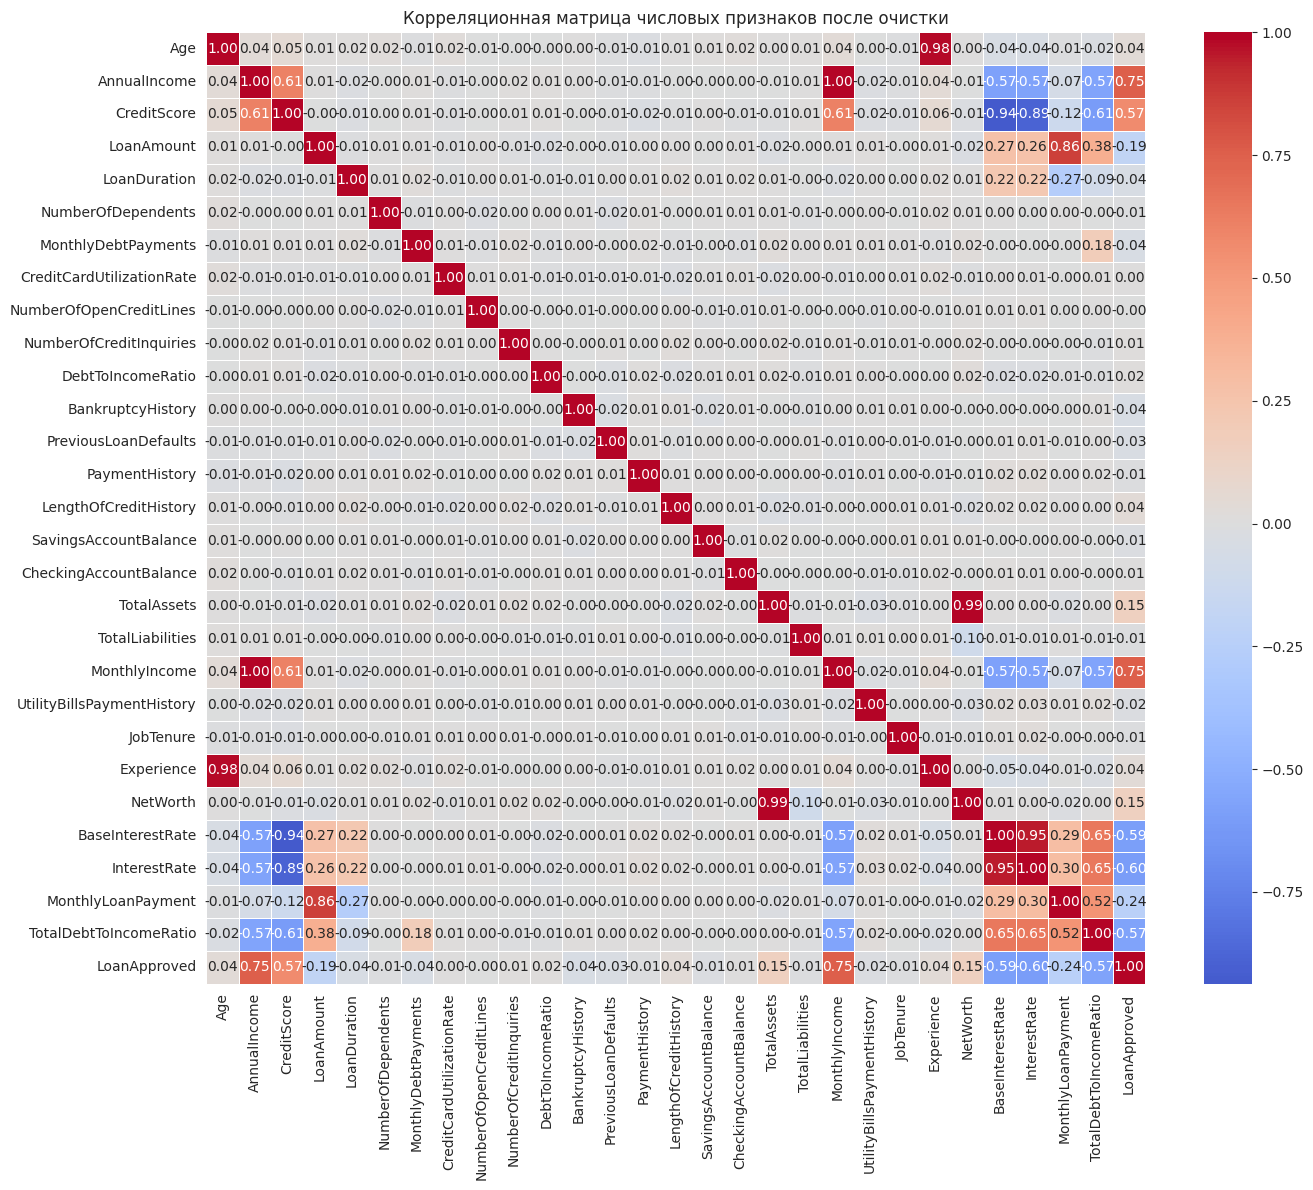

In [11]:
num_cols = df_filtered.select_dtypes(include="number").columns.drop("RiskScore")
df_num = df_filtered[num_cols].fillna(df_filtered[num_cols].median())

C = np.cov(df_num.T)
plt.figure(figsize=(14,12))
sns.heatmap(
    df_num.corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Корреляционная матрица числовых признаков после очистки")
plt.tight_layout()
plt.show()



In [12]:
# Сравнение по корреляции с таргетом
print(df_train[["BaseInterestRate", "InterestRate", "RiskScore"]].corr())


                  BaseInterestRate  InterestRate  RiskScore
BaseInterestRate          1.000000      0.951411   0.001172
InterestRate              0.951411      1.000000   0.003345
RiskScore                 0.001172      0.003345   1.000000


In [13]:
print(df_train.columns)


Index(['ApplicationDate', 'Age', 'AnnualIncome', 'CreditScore', 'LoanAmount',
       'LoanDuration', 'MaritalStatus', 'NumberOfDependents',
       'HomeOwnershipStatus', 'MonthlyDebtPayments',
       'CreditCardUtilizationRate', 'NumberOfOpenCreditLines',
       'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory',
       'LoanPurpose', 'PreviousLoanDefaults', 'PaymentHistory',
       'LengthOfCreditHistory', 'SavingsAccountBalance',
       'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities',
       'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure',
       'EmploymentStatus', 'EducationLevel', 'Experience', 'NetWorth',
       'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment',
       'TotalDebtToIncomeRatio', 'LoanApproved', 'RiskScore'],
      dtype='object')


### Объеенил Interest и BaseInterestRate

✅ InterestRate и BaseInterestRate объединены в AvgInterestRate


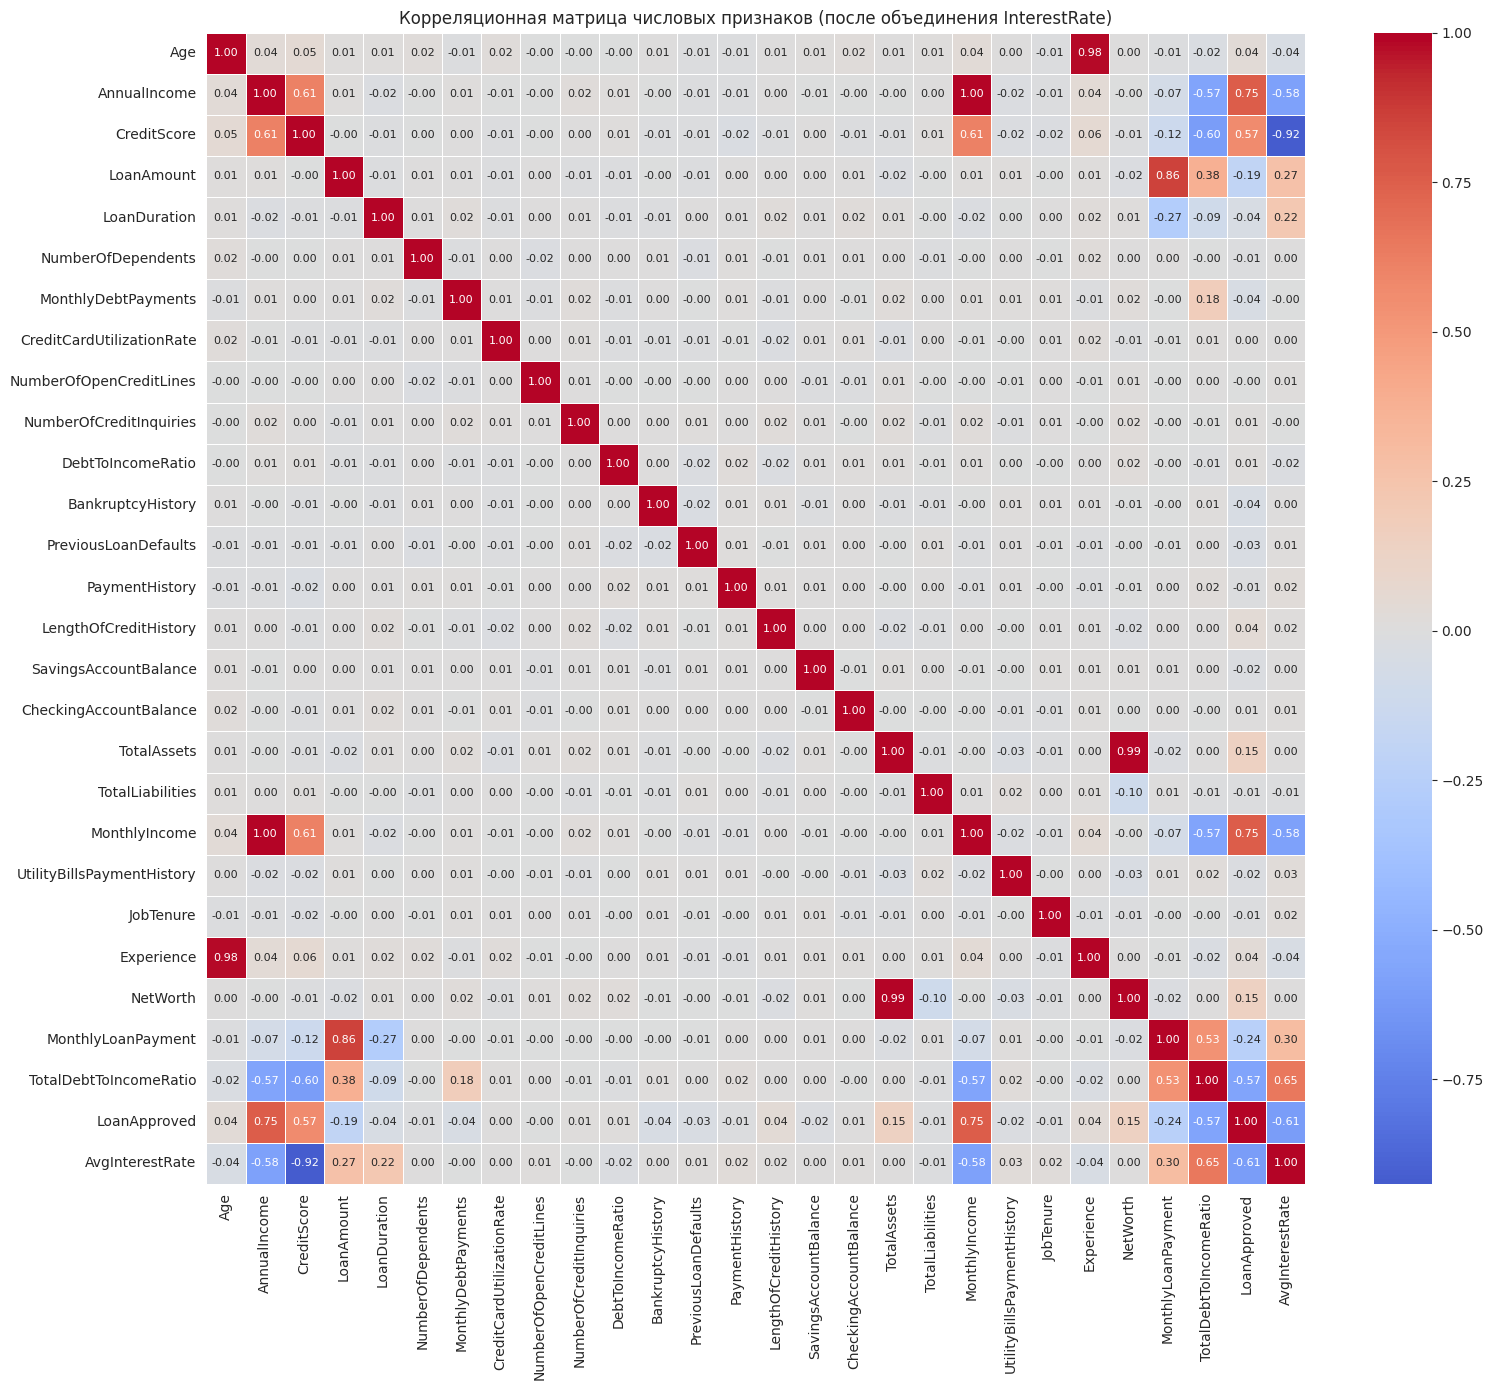

In [14]:
if "InterestRate" in df_train.columns and "BaseInterestRate" in df_train.columns:
    df_train["AvgInterestRate"] = df_train[["InterestRate", "BaseInterestRate"]].mean(axis=1)
    df_train = df_train.drop(columns=["InterestRate", "BaseInterestRate"])
    print("✅ InterestRate и BaseInterestRate объединены в AvgInterestRate")
else:
    print("⚠️ Колонки уже удалены или переименованы. Пропускаем объединение.")


# 3. Перестроим корреляционную матрицу
num_cols = df_train.select_dtypes(include="number").columns.drop("RiskScore")
df_num = df_train[num_cols].fillna(df_train[num_cols].median())

corr = df_num.corr()

# 4. Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Корреляционная матрица числовых признаков (после объединения InterestRate)")
plt.tight_layout()
plt.show()


### Удаляю Experience и Annual Income MonthlyLoanPayment, TotalAssets

In [15]:
to_remove = []

# Age vs Experience
if "Experience" in df_train.columns:
    df_train = df_train.drop(columns=["Experience"])
    to_remove.append("Experience")

# AnnualIncome vs MonthlyIncome
if "AnnualIncome" in df_train.columns:
    df_train = df_train.drop(columns=["AnnualIncome"])
    to_remove.append("AnnualIncome")

df_train = df_train.drop(columns=["TotalAssets"])
df_test = df_test.drop(columns=["TotalAssets"])
to_remove.extend(["TotalAssets"])

print("Удалены дублирующие признаки:", to_remove)


Удалены дублирующие признаки: ['Experience', 'AnnualIncome', 'TotalAssets']


In [16]:
if "MonthlyLoanPayment" in df_train.columns:
    df_train = df_train.drop(columns=["MonthlyLoanPayment"])
    print("Удалён: MonthlyLoanPayment (оставлен LoanAmount + Duration)")


Удалён: MonthlyLoanPayment (оставлен LoanAmount + Duration)


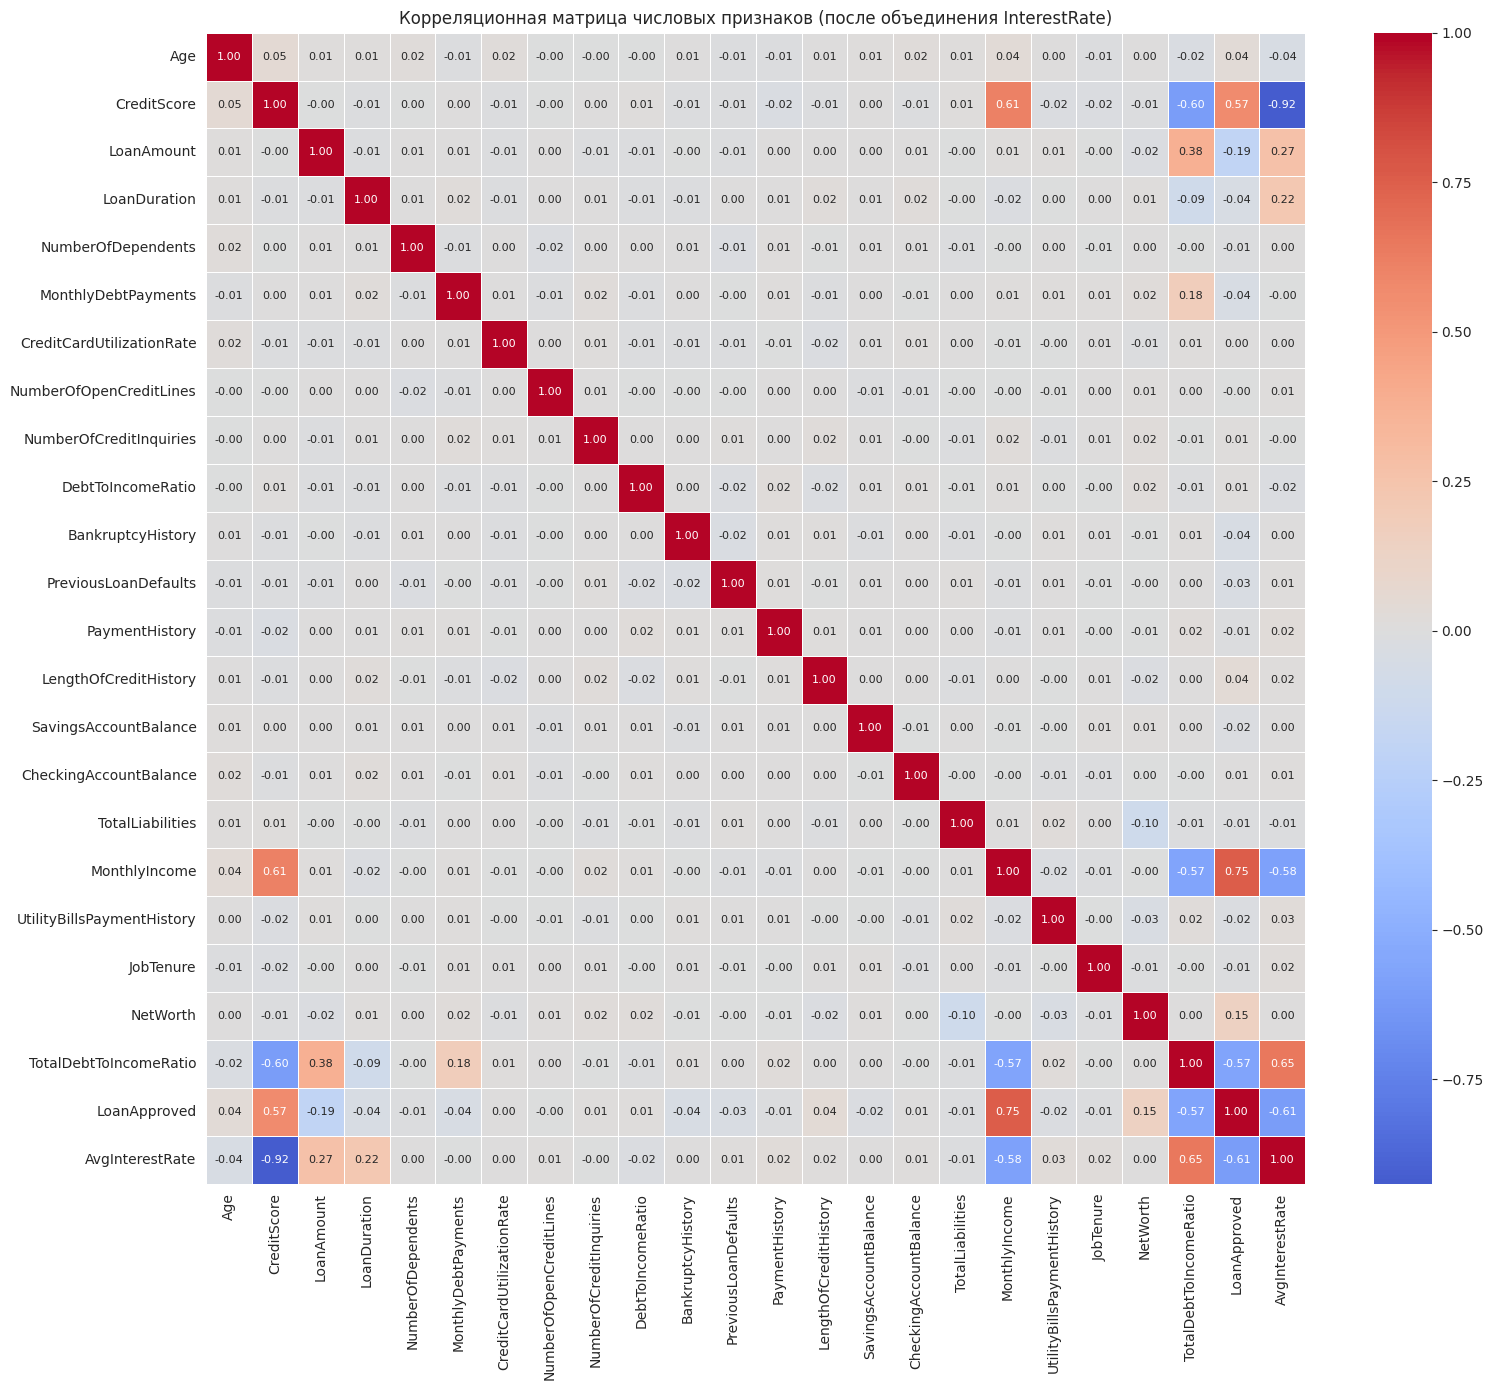

In [17]:
# 3. Перестроим корреляционную матрицу
num_cols = df_train.select_dtypes(include="number").columns.drop("RiskScore")
df_num = df_train[num_cols].fillna(df_train[num_cols].median())

corr = df_num.corr()

# 4. Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Корреляционная матрица числовых признаков (после объединения InterestRate)")
plt.tight_layout()
plt.show()


### Гистограммы всех числовых признаков

/usr/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


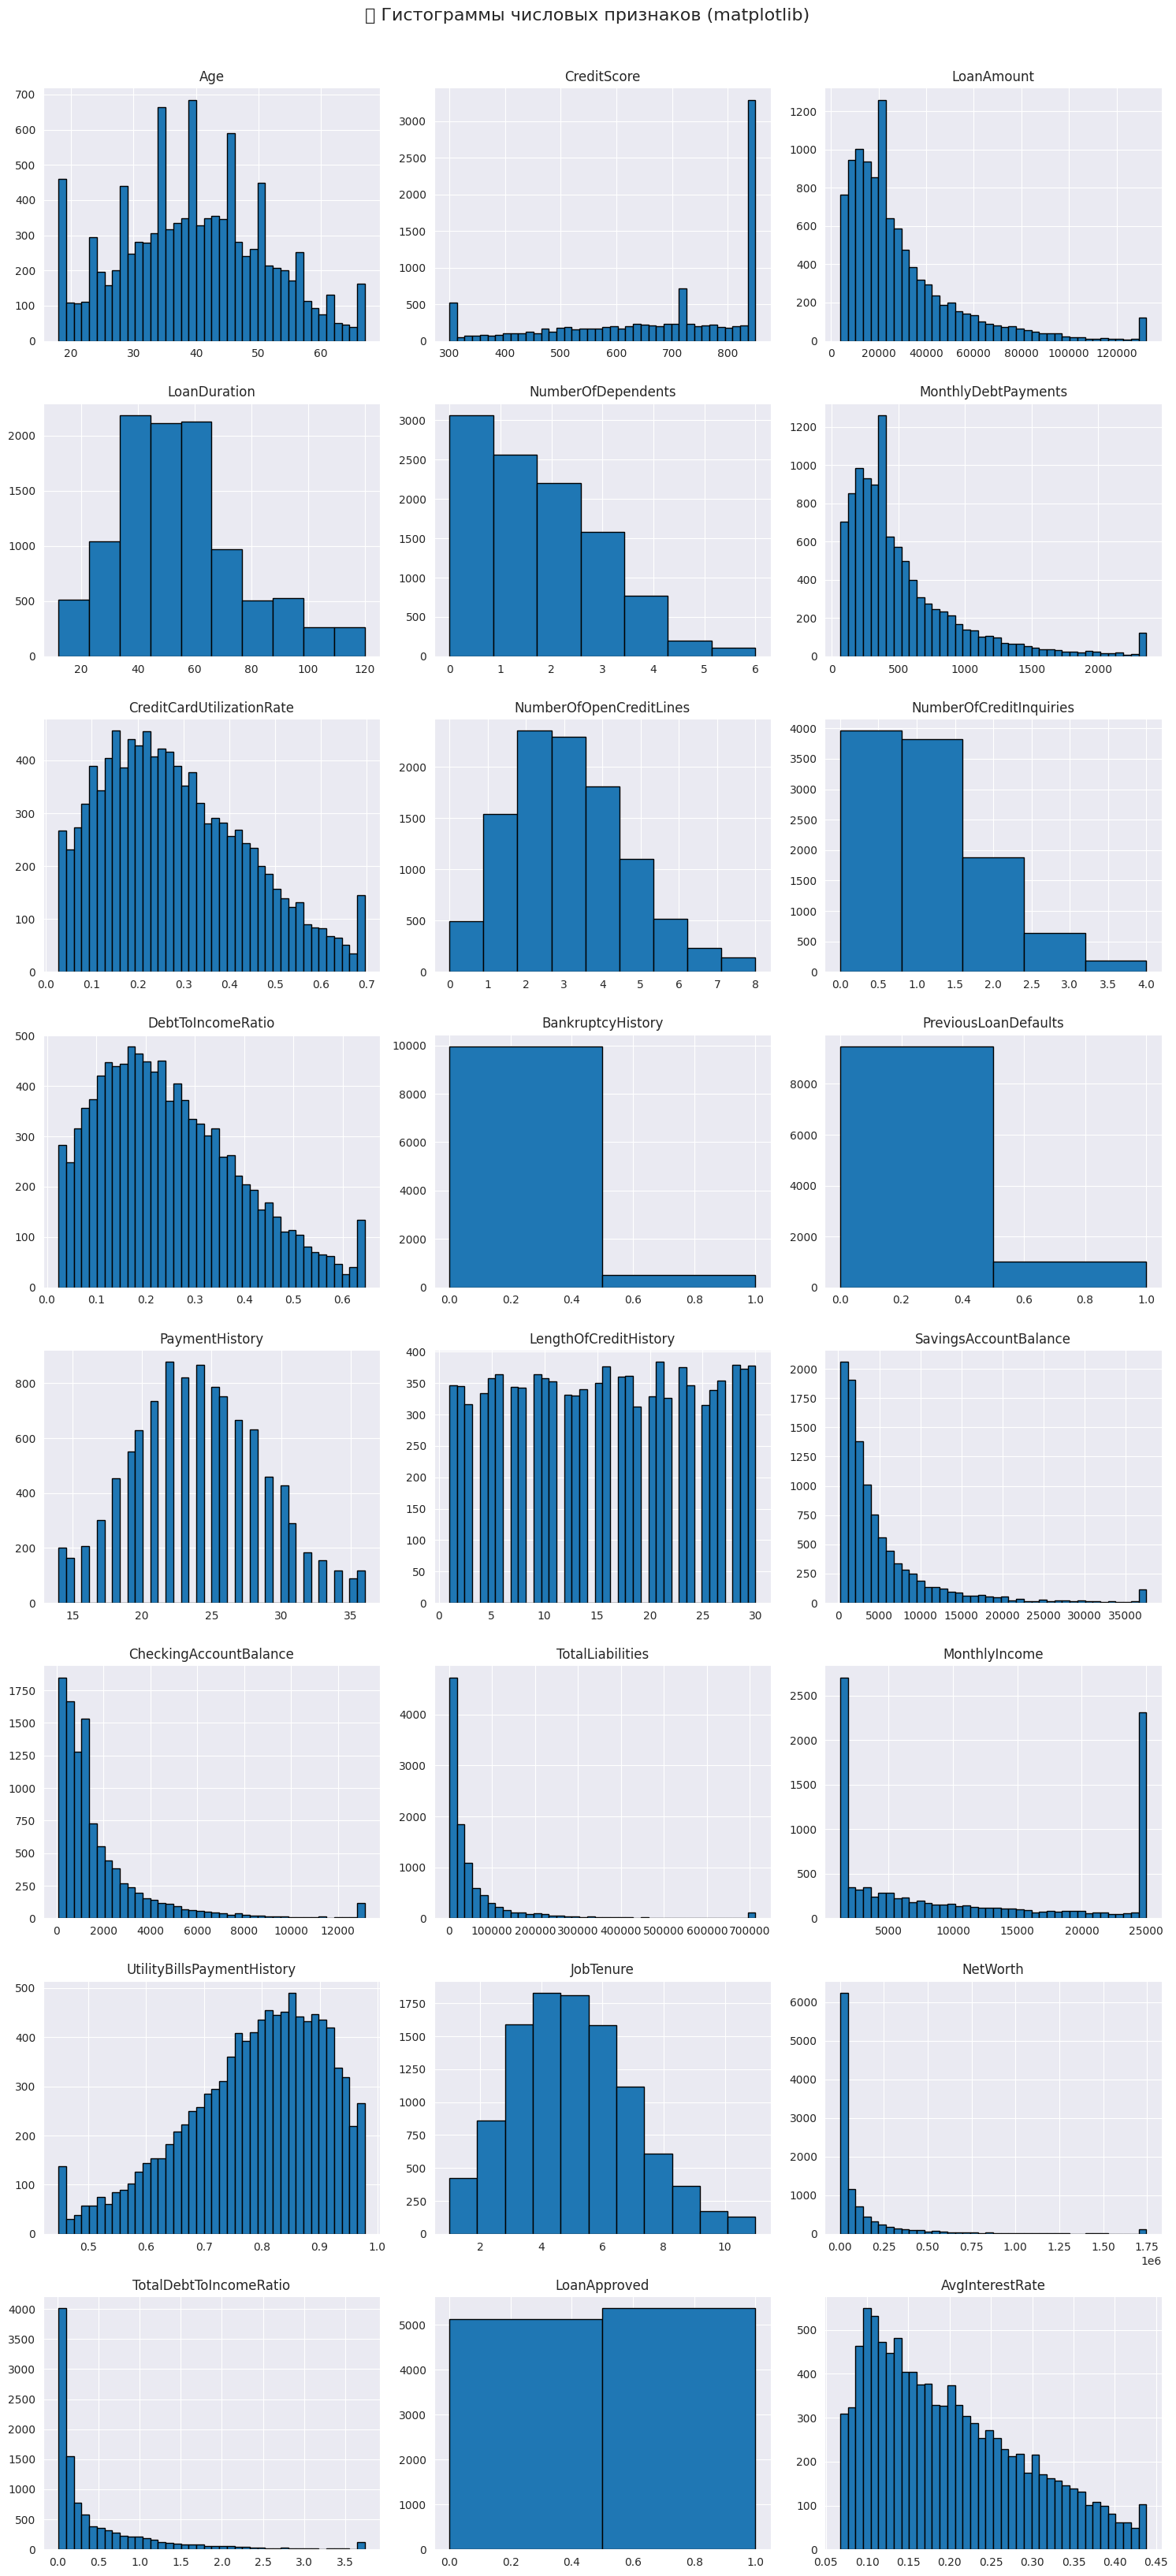

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Числовые признаки без таргета
num_cols = df_train.select_dtypes(include="number").columns.drop("RiskScore")

n = len(num_cols)
ncols = 3
nrows = (n + ncols - 1) // ncols

plt.figure(figsize=(ncols * 5, nrows * 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(nrows, ncols, i)
    data = df_train[col].dropna()

    bins = 40 if data.nunique() > 20 else data.nunique()
    plt.hist(data, bins=bins, edgecolor='black')

    plt.title(col)
    plt.grid(True)

plt.tight_layout()
plt.suptitle("📊 Гистограммы числовых признаков (matplotlib)", fontsize=16, y=1.02)
plt.show()


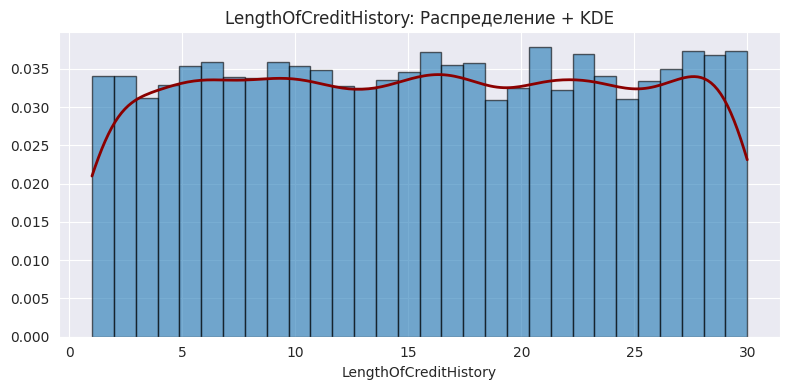

In [19]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

data = df_train["LengthOfCreditHistory"].dropna()

plt.figure(figsize=(8, 4))

# Гистограмма
plt.hist(data, bins=30, edgecolor='black', alpha=0.6, density=True)

# KDE
kde = gaussian_kde(data)
x_vals = np.linspace(data.min(), data.max(), 200)
plt.plot(x_vals, kde(x_vals), color='darkred', linewidth=2)

plt.title("LengthOfCreditHistory: Распределение + KDE")
plt.xlabel("LengthOfCreditHistory")
plt.grid(True)
plt.tight_layout()
plt.show()


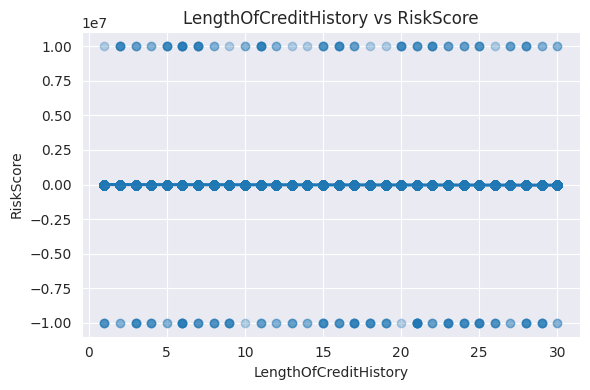

In [20]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.regplot(data=df_train, x="LengthOfCreditHistory", y="RiskScore", scatter_kws={"alpha": 0.3})
plt.title("LengthOfCreditHistory vs RiskScore")
plt.grid(True)
plt.tight_layout()
plt.show()


### Выкидываем LengthOfCreditHistory

In [21]:
df_train = df_train.drop(columns=["LengthOfCreditHistory"])
print("🗑 Удалено: LengthOfCreditHistory — равномерное, не влияет на RiskScore")


🗑 Удалено: LengthOfCreditHistory — равномерное, не влияет на RiskScore


### AGE
Он нормально распределен в бины в 5 лет - оставляем

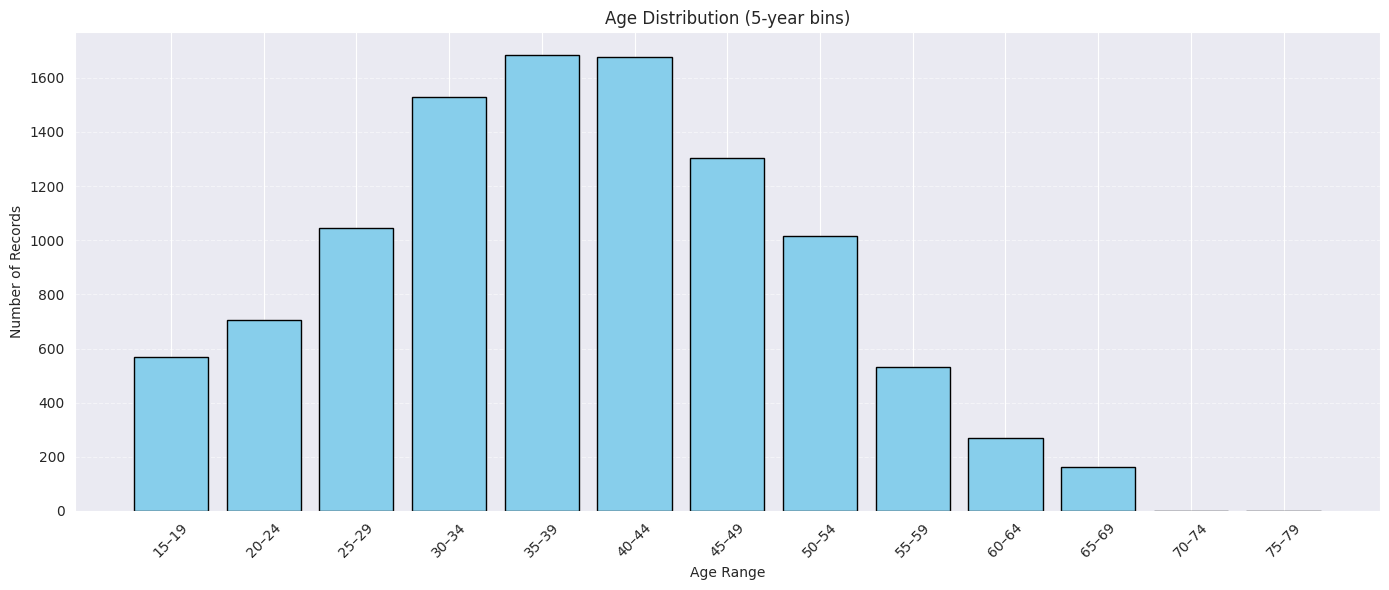

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Обрезаем пропуски
ages = df_train["Age"].dropna()

# 2. Разбиваем на интервалы (бины каждые 5 лет)
bins = pd.cut(ages, bins=range(15, 85, 5))
counts = bins.value_counts().sort_index()

# 3. Формируем подписи вида '20–24'
labels = [f"{int(i.left)}–{int(i.right) - 1}" for i in counts.index]

# 4. Рисуем
plt.figure(figsize=(14, 6))
plt.bar(labels, counts.values, color="skyblue", edgecolor="black")

plt.xticks(rotation=45)
plt.xlabel("Age Range")
plt.ylabel("Number of Records")
plt.title("Age Distribution (5-year bins)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Обработка данных

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from encoders import one_hot_encode

# --- 1. Настройка признаков ---
log_features = [
    "LoanAmount", "MonthlyDebtPayments", "NumberOfDependents",
    "SavingsAccountBalance", "CheckingAccountBalance",
    "TotalAssets", "TotalLiabilities", "NetWorth",
    "TotalDebtToIncomeRatio", "AvgInterestRate"
]

bin_features = {
    "CreditScore": [300, 600, 700, 750, 800, 850],
    "MonthlyIncome": [0, 3000, 6000, 10000, 20000, 50000, 100000]
}

# --- 2. Функция трансформации ---
def transform_features(df, log_features, bin_features, drop_first=True, return_transformed_df=False):
    df = df.copy()
    transformed_parts = []

    # 1. log1p
    for col in log_features:
        if col in df.columns:
            df[col] = df[col].clip(lower=0)
            df[col + "_log"] = np.log1p(df[col])
            transformed_parts.append(df[[col + "_log"]])

    # 2. binning + one-hot
    for col, bins in bin_features.items():
        if col in df.columns:
            binned = pd.cut(df[col], bins=bins, include_lowest=True)
            binned_encoded = pd.get_dummies(binned, prefix=col, drop_first=drop_first)
            transformed_parts.append(binned_encoded)

    # 3. Остальные числовые признаки (без RiskScore)
    numeric_cols = df.select_dtypes(include="number").columns.drop("RiskScore", errors="ignore")
    skip_cols = set(log_features + list(bin_features.keys()))
    remaining = [col for col in numeric_cols if col not in skip_cols]
    transformed_parts.append(df[remaining])

    # 4. Финальный X
    X_final = pd.concat(transformed_parts, axis=1)

    # 5. Удаление оригинальных признаков, если нужно
    cols_to_remove = log_features + list(bin_features.keys())
    df.drop(columns=[col for col in cols_to_remove if col in df.columns], inplace=True)

    if return_transformed_df:
        return X_final, df
    else:
        return X_final

# --- 3. Применение трансформации + сохранение log'ов и binned признаков в df_train ---
X_prepared, df_transformed = transform_features(df_train, log_features, bin_features, return_transformed_df=True)

# --- 4. Визуализация по обработанному df ---
num_cols = df_transformed.select_dtypes(include="number").columns.drop("RiskScore", errors="ignore")

n = len(num_cols)
ncols = 3
nrows = (n + ncols - 1) // ncols

plt.figure(figsize=(ncols * 5, nrows * 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(nrows, ncols, i)
    data = df_transformed[col].dropna()

    bins = 40 if data.nunique() > 20 else data.nunique()
    plt.hist(data, bins=bins, edgecolor='black', alpha=0.6, density=True)

    if data.nunique() > 10:
        kde = gaussian_kde(data)
        x_vals = np.linspace(data.min(), data.max(), 200)
        plt.plot(x_vals, kde(x_vals), color='darkred', linewidth=2)

    plt.title(col)
    plt.grid(True)

plt.tight_layout()
plt.suptitle("📊 Распределения после трансформации", fontsize=16, y=1.02)
plt.show()


### Заметим что NumberOfCreditInquiries  NumberOfDependents_log - странные отменим у них log

/usr/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


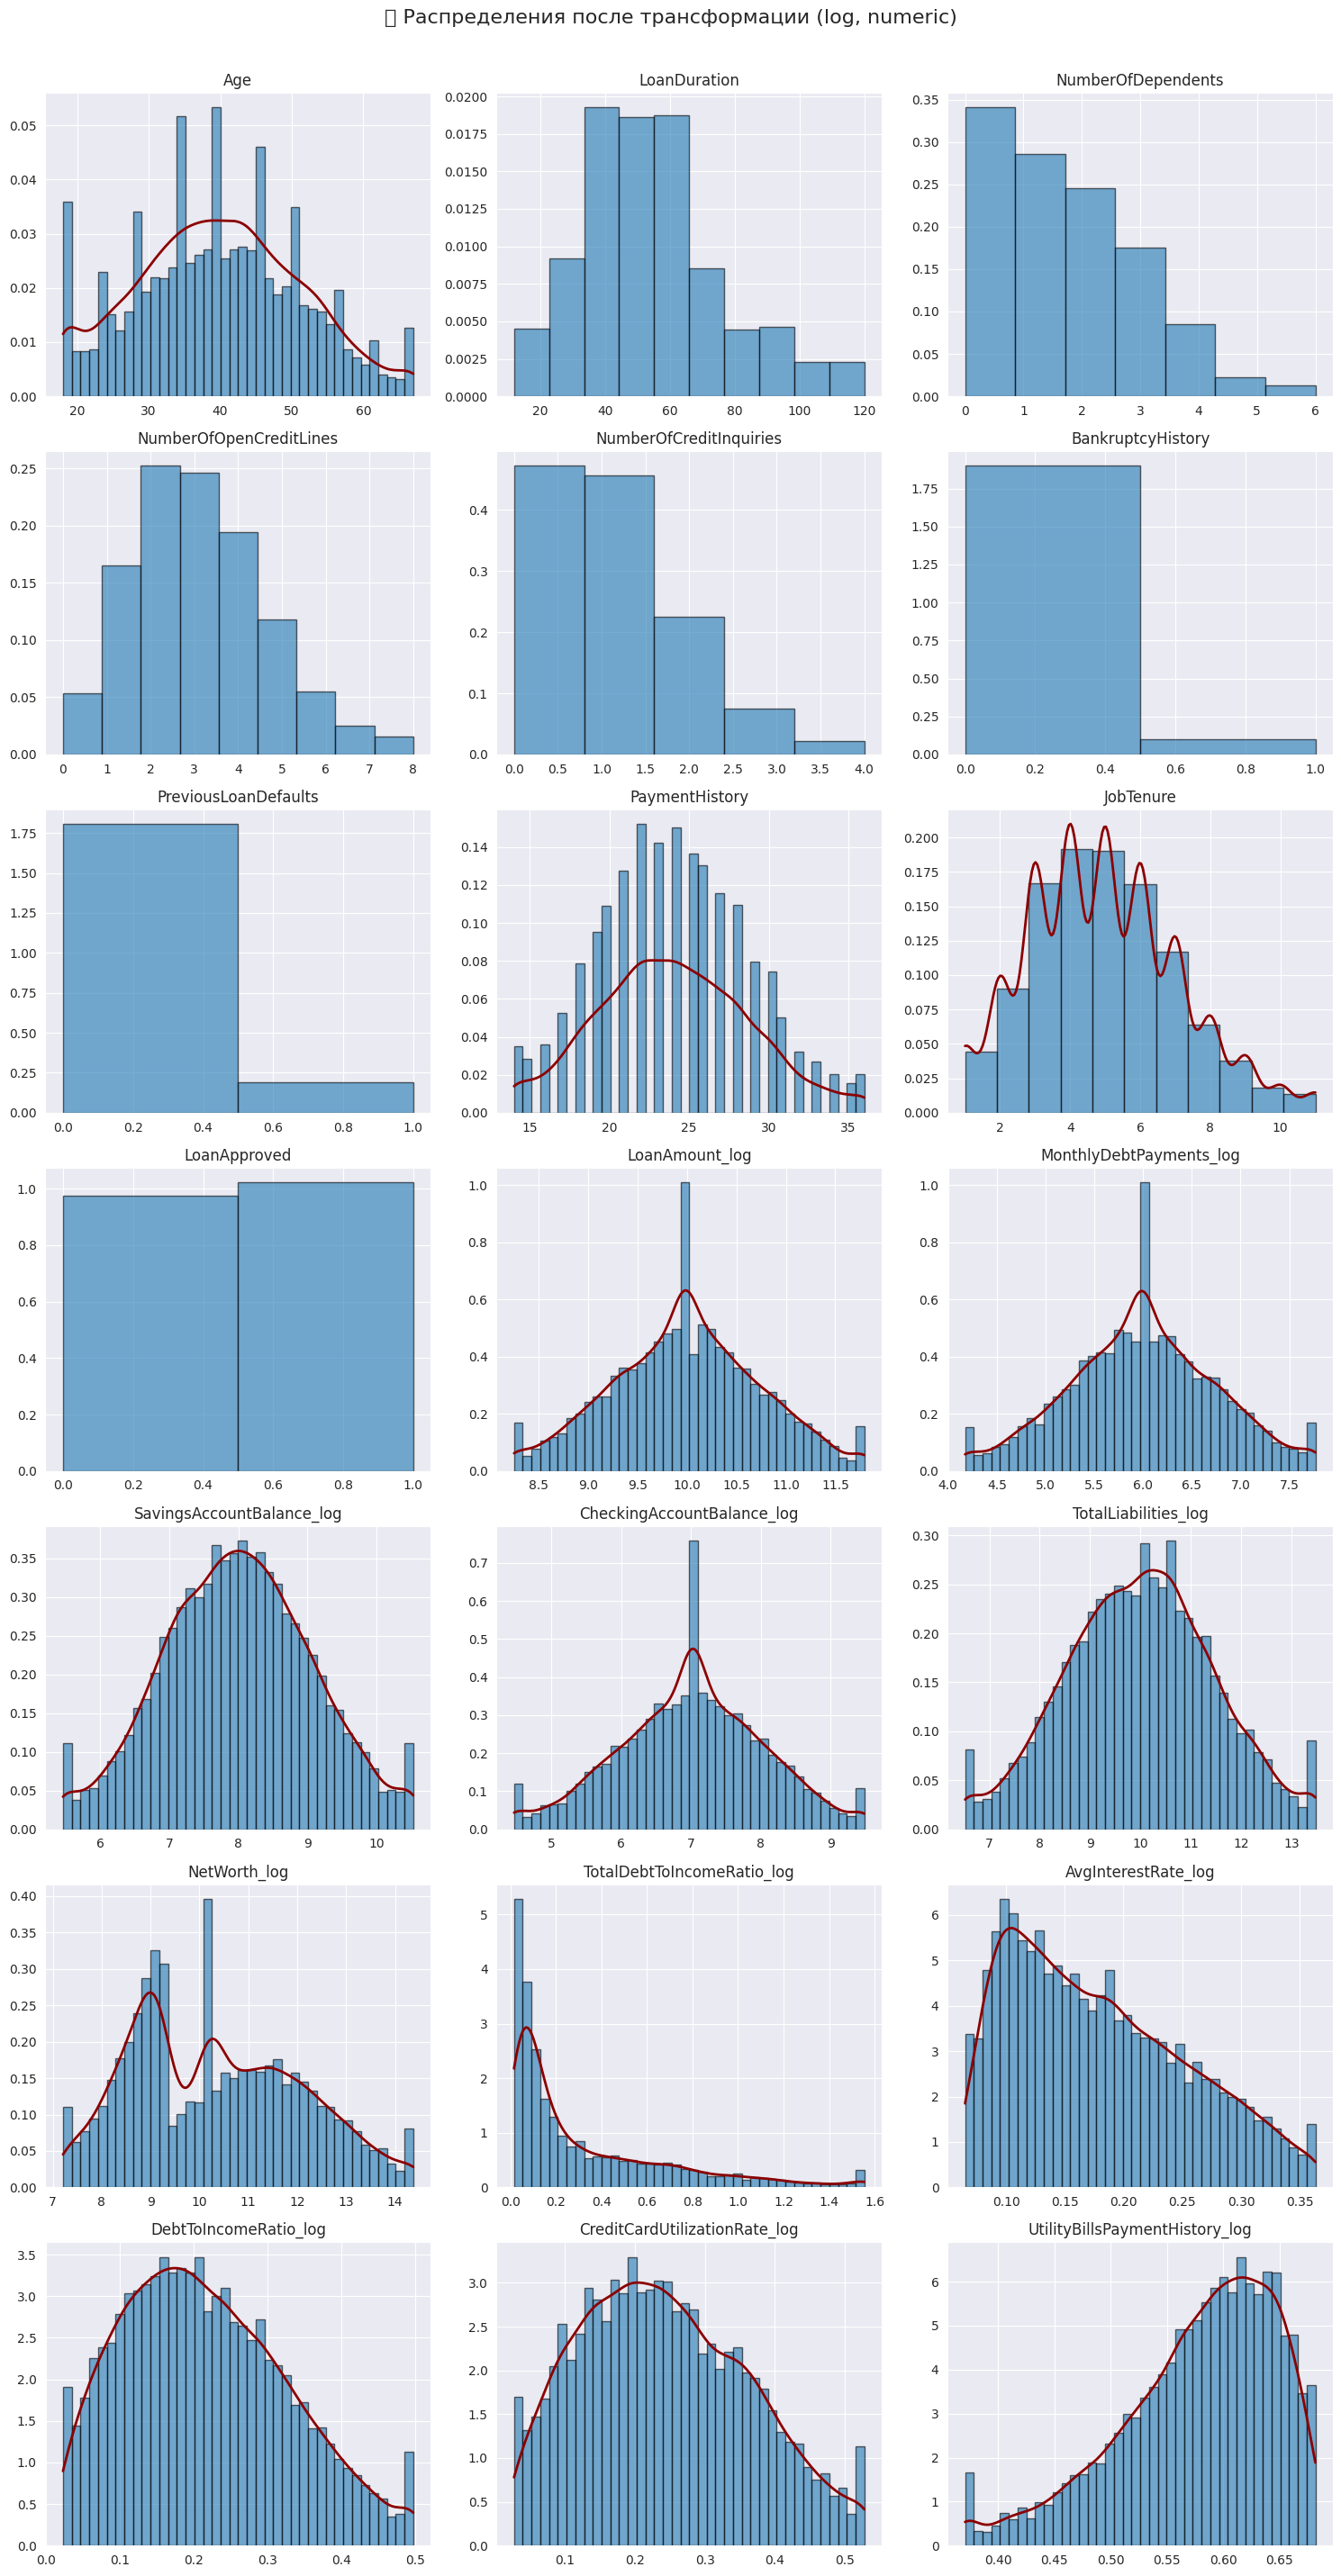

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from encoders import one_hot_encode

# --- 1. Настройка признаков ---
log_features = [
    "LoanAmount", "MonthlyDebtPayments",
    "SavingsAccountBalance", "CheckingAccountBalance",
    "TotalAssets", "TotalLiabilities", "NetWorth",
    "TotalDebtToIncomeRatio", "AvgInterestRate",
    "DebtToIncomeRatio", "CreditCardUtilizationRate",
    "UtilityBillsPaymentHistory"
]  # <- убран NumberOfDependents

bin_features = {
    "CreditScore": [300, 600, 700, 750, 800, 850],
    "MonthlyIncome": [0, 3000, 6000, 10000, 20000, 50000, 100000]
}

# --- 2. Функция трансформации ---
def transform_features(df, log_features, bin_features, drop_first=True, return_transformed_df=False):
    df = df.copy()
    transformed_parts = []

    # 1. log1p
    for col in log_features:
        if col in df.columns:
            df[col] = df[col].clip(lower=0)
            df[col + "_log"] = np.log1p(df[col])
            transformed_parts.append(df[[col + "_log"]])

    # 2. binning + one-hot
    for col, bins in bin_features.items():
        if col in df.columns:
            binned = pd.cut(df[col], bins=bins, include_lowest=True)
            binned_encoded = pd.get_dummies(binned, prefix=col, drop_first=drop_first)
            transformed_parts.append(binned_encoded)

    # 3. Остальные числовые признаки (без RiskScore)
    numeric_cols = df.select_dtypes(include="number").columns.drop("RiskScore", errors="ignore")
    skip_cols = set(log_features + list(bin_features.keys()))
    remaining = [col for col in numeric_cols if col not in skip_cols]
    transformed_parts.append(df[remaining])

    # 4. Финальный X
    X_final = pd.concat(transformed_parts, axis=1)

    # 5. Удаление оригинальных признаков
    cols_to_remove = log_features + list(bin_features.keys())
    df.drop(columns=[col for col in cols_to_remove if col in df.columns], inplace=True)

    if return_transformed_df:
        return X_final, df
    else:
        return X_final

# --- 3. Применение трансформации + сохранение log'ов и binned признаков в df_train ---
X_prepared, df_transformed = transform_features(df_train, log_features, bin_features, return_transformed_df=True)

# --- 4. Визуализация по обработанному df ---
# Только числовые признаки (логарифмированные и оставшиеся)
num_cols = [col for col in df_transformed.columns if col != "RiskScore" and np.issubdtype(df_transformed[col].dtype, np.number)]

n = len(num_cols)
ncols = 3
nrows = (n + ncols - 1) // ncols

plt.figure(figsize=(ncols * 5, nrows * 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(nrows, ncols, i)
    data = df_transformed[col].dropna()

    bins = 40 if data.nunique() > 20 else data.nunique()
    plt.hist(data, bins=bins, edgecolor='black', alpha=0.6, density=True)

    if data.nunique() > 10:
        kde = gaussian_kde(data)
        x_vals = np.linspace(data.min(), data.max(), 200)
        plt.plot(x_vals, kde(x_vals), color='darkred', linewidth=2)

    plt.title(col)
    plt.grid(True)

plt.tight_layout()
plt.suptitle("📊 Распределения после трансформации (log, numeric)", fontsize=16, y=1.02)
plt.show()


### Перейдем к категориальным

In [24]:
cat_cols = df_train.select_dtypes(include=["object", "category"]).columns
df_train[cat_cols].nunique().sort_values()


EmploymentStatus           3
MaritalStatus              4
HomeOwnershipStatus        4
EducationLevel             5
LoanPurpose                6
ApplicationDate        10000
dtype: int64

In [25]:
# Признаки с малым числом уникальных значений
categorical_cols = [
    "EmploymentStatus", "MaritalStatus", "HomeOwnershipStatus",
    "LoanPurpose", "EducationLevel"
]

df_cat_encoded = pd.get_dummies(df_train[categorical_cols], drop_first=True, prefix=categorical_cols)

# Объединение с основным датафреймом
df_train = pd.concat([df_train.drop(columns=categorical_cols), df_cat_encoded], axis=1)


# Datetime превратим в числовой

In [26]:
# Убедимся, что это datetime
df_train["ApplicationDate"] = pd.to_datetime(df_train["ApplicationDate"], errors="coerce")

# Извлекаем полезные признаки
df_train["AppWeekday"] = df_train["ApplicationDate"].dt.weekday  # 0=Пн, 6=Вс
df_train["AppMonth"] = df_train["ApplicationDate"].dt.month
df_train["AppDaysSinceStart"] = (df_train["ApplicationDate"] - df_train["ApplicationDate"].min()).dt.days

# Удаляем оригинальную дату
df_train = df_train.drop(columns=["ApplicationDate"])


### Вернемся к числовым

CreditScore                    — AvgInterestRate                → 0.92
MonthlyIncome                  — LoanApproved                   → 0.75
TotalDebtToIncomeRatio         — AvgInterestRate                → 0.65
MaritalStatus_Married          — MaritalStatus_Single           → 0.65
CreditScore                    — MonthlyIncome                  → 0.61
LoanApproved                   — AvgInterestRate                → 0.61
CreditScore                    — TotalDebtToIncomeRatio         → 0.60
MonthlyIncome                  — AvgInterestRate                → 0.58
TotalDebtToIncomeRatio         — LoanApproved                   → 0.57
CreditScore                    — LoanApproved                   → 0.57
MonthlyIncome                  — TotalDebtToIncomeRatio         → 0.57
EducationLevel_Bachelor        — EducationLevel_High School     → 0.53
LoanAmount                     — TotalDebtToIncomeRatio         → 0.38
LoanPurpose_Debt Consolidation — LoanPurpose_Home               → 0.35
HomeOw

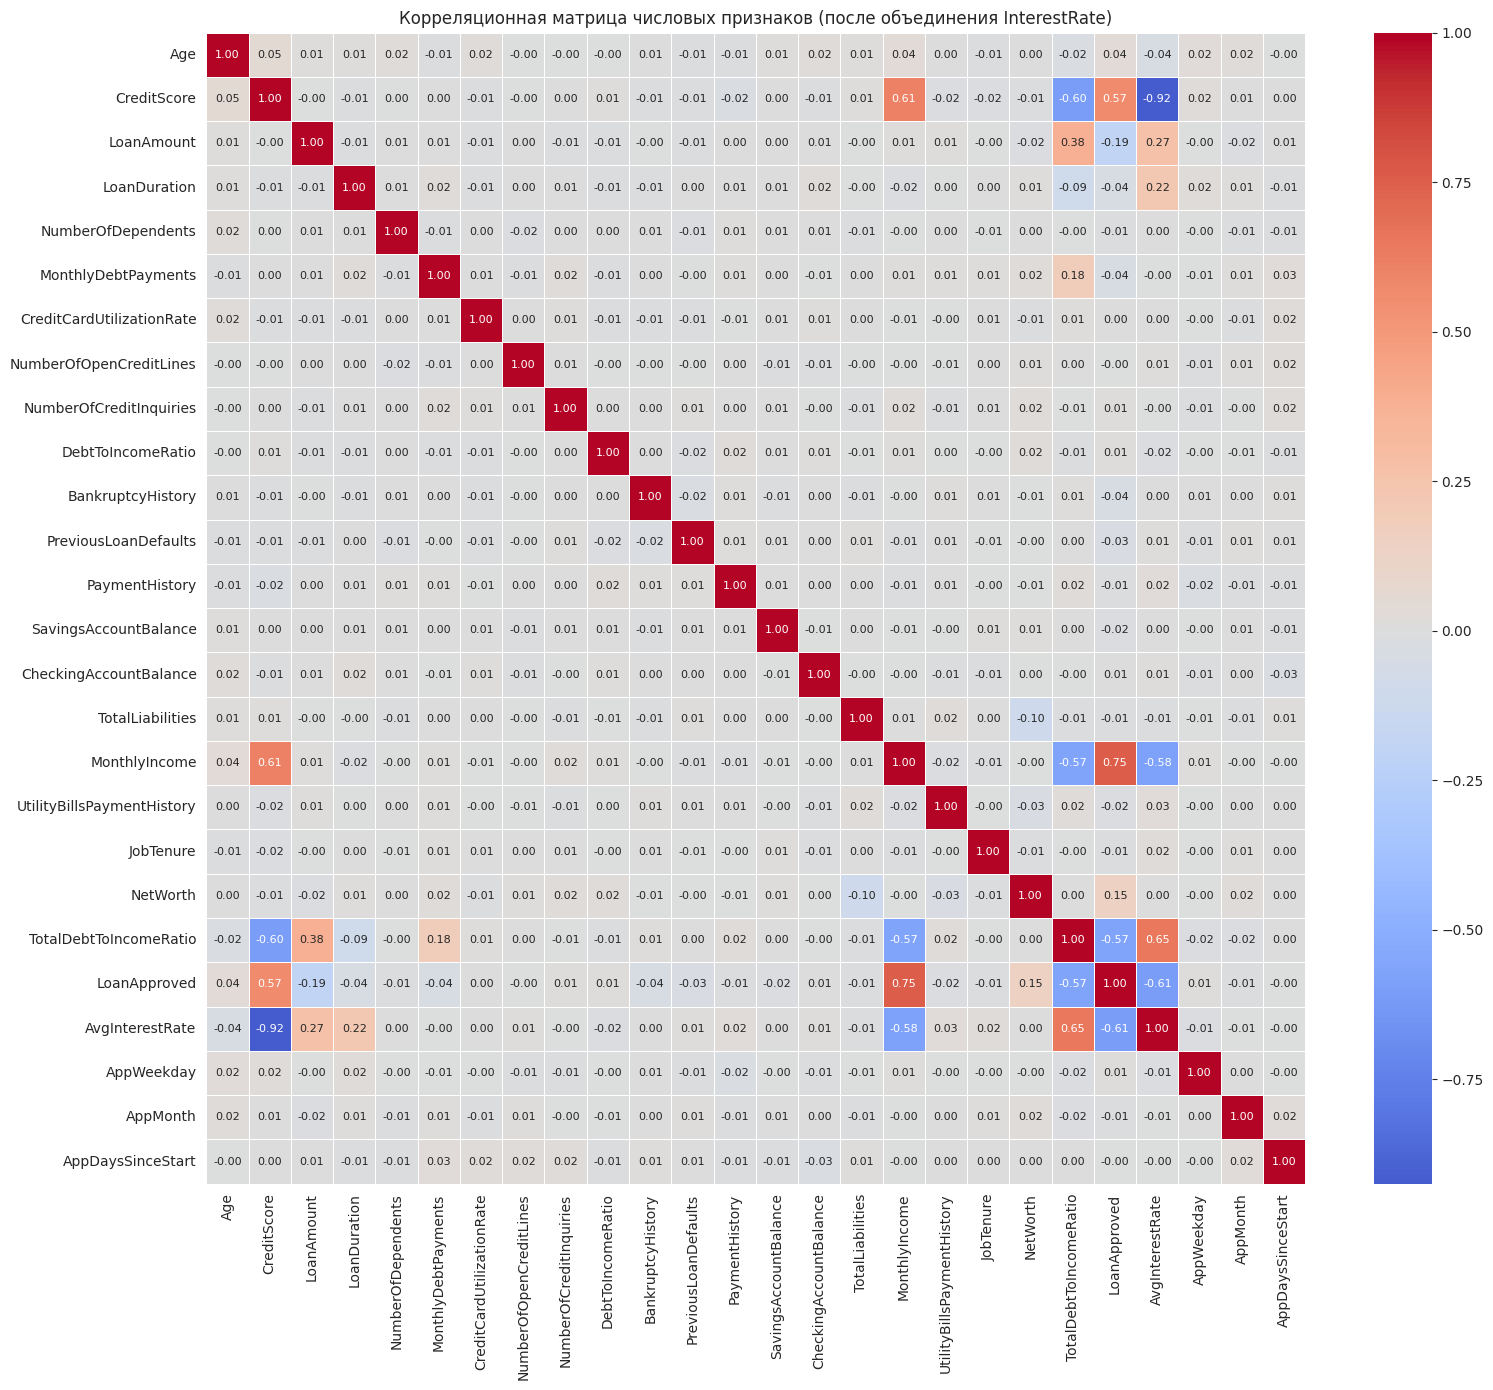

In [27]:
def get_correlated_pairs(df, threshold=0.15):
    corr_matrix = df.corr().abs()
    correlated_pairs = []

    # Проходим только по верхнему треугольнику матрицы, без диагонали
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr = corr_matrix.iloc[i, j]
            if corr > threshold:
                correlated_pairs.append((col1, col2, corr))

    # Сортировка по убыванию корреляции
    correlated_pairs = sorted(correlated_pairs, key=lambda x: abs(x[2]), reverse=True)

    return correlated_pairs

# Пример использования
correlated = get_correlated_pairs(df_train, threshold=0.15)
for col1, col2, corr in correlated:
    print(f"{col1:30} — {col2:30} → {corr:.2f}")

    num_cols = df_train.select_dtypes(include="number").columns.drop("RiskScore")
df_num = df_train[num_cols].fillna(df_train[num_cols].median())

corr = df_num.corr()

# 4. Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Корреляционная матрица числовых признаков (после объединения InterestRate)")
plt.tight_layout()
plt.show()


 ### Сделаем фичу с MonthlyIncome TotalDebtToIncomeRatio AvgInterestRate LoanApproved

In [29]:
from linear_regression import LinearRegressionManual
from normalization import normalize_zscore

# --- Шаг 1: исходные признаки
financial_cols = ["MonthlyIncome", "TotalDebtToIncomeRatio", "AvgInterestRate", "LoanApproved"]
X_raw = df_train[financial_cols].copy()
X_raw = X_raw.fillna(X_raw.median())  # защита

# --- Шаг 2: нормализация Z-score для вычисления весов
X_norm, _ = normalize_zscore(X_raw)

# --- Шаг 3: обучаем модель на нормализованных признаках
y = df_train["RiskScore"].values
model = LinearRegressionManual(method="analytic")
model.fit(X_norm, y)

# --- Шаг 4: получаем нормализованные веса и применяем их на ОРИГИНАЛ
weights = dict(zip(financial_cols, model.coef_))

df_train["FinancialIndex"] = sum(weights[col] * X_raw[col] for col in financial_cols)
df_train["FinancialIndex_log"] = np.log1p(df_train["FinancialIndex"])

# --- Печатаем веса

print("📊 Нормализованные веса (по Z-score):")
for col in financial_cols:
    print(f"{col:30} → {weights[col]:.3f}")


📊 Нормализованные веса (по Z-score):
MonthlyIncome                  → 17194.056
TotalDebtToIncomeRatio         → 35566.776
AvgInterestRate                → -27457.522
LoanApproved                   → -28865.383


/tmp/ipykernel_472281/1768169930.py:33: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


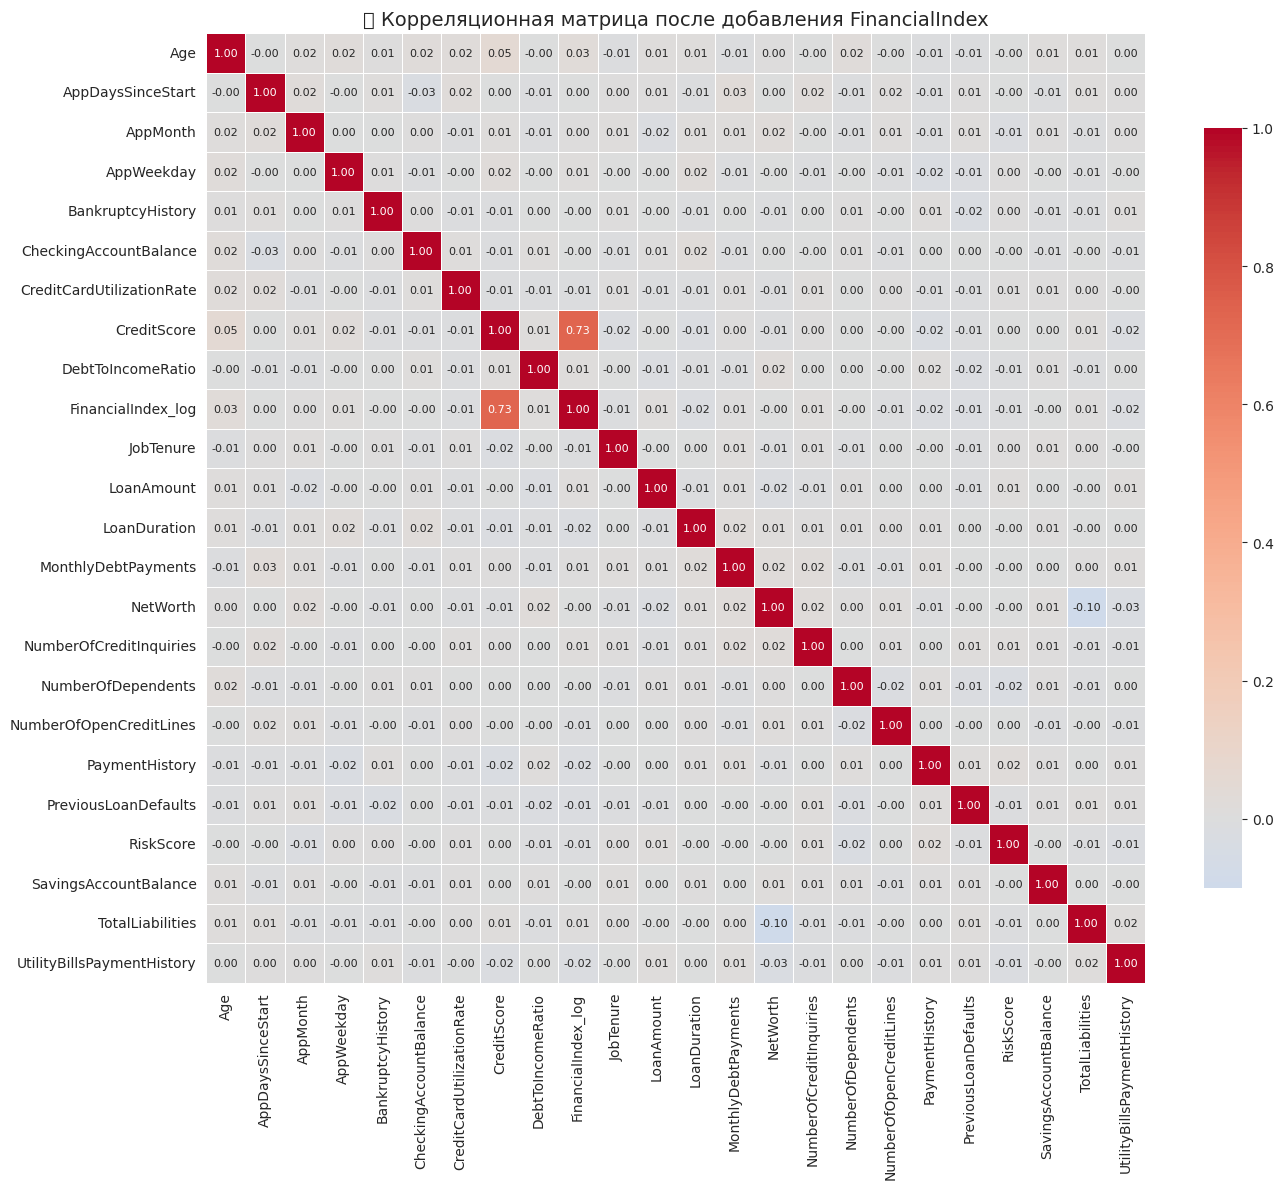

In [30]:
# --- Признаки, из которых строился индекс
financial_cols = ["MonthlyIncome", "TotalDebtToIncomeRatio", "AvgInterestRate", "LoanApproved"]

# --- Добавляем FinancialIndex + логарифм
# --- Добавляем FinancialIndex + логарифм
df_train["FinancialIndex"] = sum(weights[col] * df_train[col] for col in financial_cols)
df_train["FinancialIndex_log"] = np.log1p(df_train["FinancialIndex"])

# --- Удаляем исходные признаки и необработанный индекс
df_train.drop(columns=financial_cols + ["FinancialIndex"], inplace=True, errors="ignore")

# --- Обновлённый список числовых признаков
num_cols = df_train.select_dtypes(include="number").columns.drop("RiskScore", errors="ignore")

# --- Корреляционная матрица
import matplotlib.pyplot as plt
import seaborn as sns

corr = df_train[num_cols.union(["RiskScore", "FinancialIndex_log"])].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr,
    annot=True, fmt=".2f",
    cmap="coolwarm", center=0,
    linewidths=0.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}
)
plt.title("🔍 Корреляционная матрица после добавления FinancialIndex", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
